In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
nba = pd.read_csv("NBADataJan122024.csv")
#get rid of Rk column as it it just an ID number
nba = nba.drop(columns=nba.columns[0])

nba.head()

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,WINS,LOSSES
0,Memphis Grizzlies,39,240.0,44.9,93.2,0.482,14.0,38.0,0.368,30.9,...,35.4,48.5,29.9,9.2,6.4,17.3,21.3,123.0,25,14
1,Cleveland Cavaliers,37,240.0,45.2,89.6,0.505,16.3,40.4,0.405,28.9,...,33.8,43.6,29.4,8.8,4.6,13.0,18.2,122.9,33,4
2,Denver Nuggets,37,242.7,45.1,90.4,0.499,11.9,31.1,0.382,33.2,...,34.4,45.3,31.5,8.8,4.7,14.1,18.1,120.6,22,15
3,Chicago Bulls,38,240.7,43.4,92.3,0.471,16.4,43.8,0.375,27.0,...,35.9,45.3,29.6,7.7,4.7,15.1,18.1,118.2,18,20
4,Boston Celtics,38,242.0,41.6,90.6,0.460,18.0,49.5,0.364,23.6,...,34.0,44.9,25.4,7.6,5.7,12.0,16.1,117.9,27,11


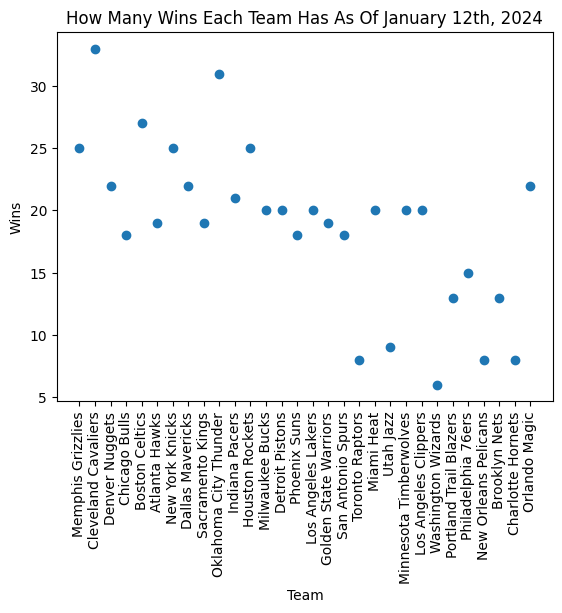

In [14]:
plt.scatter(nba.Team, nba.WINS)
plt.title("How Many Wins Each Team Has As Of January 12th, 2024")
plt.xlabel("Team")
plt.ylabel("Wins")
plt.xticks(rotation=90)
plt.show()